In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import torch
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
#import csv
import sys as sys
from numpy import array
from numpy import argmax
from operator import itemgetter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
from collections import defaultdict

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

torch.manual_seed(1)

In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
def remove_single_actions(df):
  df = df.drop(df[(df['action_type'] == "clickout item") & (df['step'] == 1)].index)
  return df
  
def remove_test_single_actions(df_test, df_gt):
  df_sessions = df_test.groupby('session_id')

  for group_name, df_group in df_sessions:
    session_len = 0

    for action_index, action in df_group.iterrows():
      session_len = session_len + 1
    
    if session_len == 1:
      df_test = df_test.drop(df_test[df_test['session_id'] == action['session_id']].index)
      df_gt = df_gt.drop(df_gt[df_gt['session_id'] == action['session_id']].index)
      #df = df.drop(df[(df['action_type'] == "clickout item") & (df['step'] == 1)].index)
    
  return df_test, df_gt  
  
def remove_nonitem_actions(df):
  df = df.drop(df[(df['action_type'] != 'interaction item image') & (df['action_type'] != 'interaction item deals') & (df['action_type'] != 'clickout item') & (df['action_type'] != 'search for item')].index)
  return df

def reduce_df(df, dim):
  df = df.head(dim)
  return pd.DataFrame(df)

def get_corpus(df):
  session_id = ''
  temp_session = []
  splitted_sessions = []

  for action_index, action in df.iterrows():
    if session_id == '':
      session_id = action['session_id']

    if session_id != action['session_id']:
      splitted_sessions.append(temp_session)
      temp_session = []

    temp_session.append(action['reference'])
    session_id = action['session_id']

  return splitted_sessions

In [0]:
#importing taining
link_encode = 'https://drive.google.com/open?id=1C8uIb4rwzWKMB6MDXuxpm7DNLuw_7KzM'
fluff, id_encode = link_encode.split('=')
downloaded = drive.CreateFile({'id':id_encode}) 
downloaded.GetContentFile('encode.csv')

In [0]:
df_encode = pd.read_csv("./encode.csv")
df_encode = remove_single_actions(df_encode)
df_encode = remove_nonitem_actions(df_encode)

In [0]:
len(df_encode)

134604

In [0]:
df_encode = reduce_df(df_encode, 80000)

In [0]:
#importing taining
link_train = 'https://drive.google.com/open?id=11r6pEFf4PO5GGGEO1Ll0qp6jHG4TmIx5'
fluff, id_train = link_train.split('=')
downloaded = drive.CreateFile({'id':id_train}) 
downloaded.GetContentFile('train.csv')

In [0]:
df_train = pd.read_csv("./train.csv")
df_train = remove_single_actions(df_train)
df_train =  remove_nonitem_actions(df_train)

In [0]:
df_train = reduce_df(df_train, 10000)

In [0]:
#importing test set
link_test = 'https://drive.google.com/open?id=1iigsXE1mcrwOLkrUPpPoWWTa01dKTpTj'
fluff, id_test = link_test.split('=')
downloaded = drive.CreateFile({'id':id_test}) 
downloaded.GetContentFile('test.csv')

In [0]:
df_test = pd.read_csv("./test.csv")
df_test = remove_single_actions(df_test)
df_test = remove_nonitem_actions(df_test)

In [0]:
df_test = reduce_df(df_test, 1000)

In [0]:
#importing ground truth
link_gt = 'https://drive.google.com/open?id=16pDsLkxsQapmWUAuRkWaMZ16U8IBLqsj'
fluff, id_gt = link_gt.split('=')
downloaded = drive.CreateFile({'id':id_gt})
downloaded.GetContentFile('gt.csv')

In [0]:
df_gt = pd.read_csv("./gt.csv")

In [0]:
df_gt = reduce_df(df_gt, 1000)

In [0]:
df_test, df_gt = remove_test_single_actions(df_test, df_gt)

In [0]:
corpus = get_corpus(df_encode)

gensim trial

In [0]:
from gensim.models import Word2Vec

In [0]:
def normalize_word2vec(word2vec):
  hotels_pre_norm = []

  for hotel in word2vec.wv.index2word:
    hotels_pre_norm.append(word2vec.wv[hotel].tolist())

  hotels_pre_norm = np.asarray(hotels_pre_norm)
  hotels_post_norm = normalize(hotels_pre_norm, norm='l2', axis=0, copy=True, return_norm=False)
  
  hotels_post_norm = hotels_post_norm.tolist()

  for hotel in word2vec.wv.index2word:
    word2vec.wv[hotel] = np.asarray(hotels_post_norm[0])
    hotels_post_norm.pop(0)
    
  return word2vec

In [0]:
word2vec = Word2Vec(corpus, min_count=1, window=3, sg=1) 

In [0]:
n_features = len(word2vec.wv['666856'])
n_features

100

In [0]:
word2vec.wv['666856']

array([ 0.03526263, -0.17496549, -0.09631828,  0.07456572, -0.03572379,
       -0.06908759,  0.10877193,  0.08471549,  0.13518414, -0.00801464,
        0.16815111,  0.04593981,  0.1209075 ,  0.064583  , -0.08734575,
        0.06686211, -0.04323595,  0.02856096, -0.03304977, -0.02166802,
       -0.09425514,  0.03557717,  0.05386445,  0.10141018, -0.11770596,
       -0.05925402,  0.02488073, -0.11556243,  0.07524591, -0.07580371,
       -0.07364979, -0.05535391, -0.05282104, -0.0076453 ,  0.05119555,
       -0.06390543,  0.06552534, -0.05736761,  0.00409692,  0.06475112,
        0.0249147 ,  0.00534055, -0.08861294,  0.02973771,  0.02100789,
        0.0042786 ,  0.12793148, -0.03538985,  0.01552989, -0.01331454,
       -0.01790412,  0.03313057,  0.09941702,  0.0086852 ,  0.02350247,
       -0.00856307, -0.02948254, -0.13649791, -0.00230284, -0.00960839,
       -0.08256794, -0.04463514,  0.12775898,  0.08426239,  0.09193534,
       -0.06190479,  0.20085596,  0.00802595,  0.07278528,  0.11

In [0]:
word2vec.wv.most_similar(positive = '4102552')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('5502296', 0.9928935766220093),
 ('8893082', 0.9857744574546814),
 ('17272', 0.9853560924530029),
 ('61095', 0.9851547479629517),
 ('8242182', 0.9851395487785339),
 ('1833415', 0.9850159883499146),
 ('5911872', 0.9844184517860413),
 ('1240282', 0.9841992259025574),
 ('3860374', 0.9841625690460205),
 ('2716916', 0.9841260313987732)]

In [0]:
#hotel_dict = normalize_word2vec(word2vec.wv)
hotel_dict = word2vec.wv

In [0]:
word2vec.wv['666856']

array([ 0.03526263, -0.17496549, -0.09631828,  0.07456572, -0.03572379,
       -0.06908759,  0.10877193,  0.08471549,  0.13518414, -0.00801464,
        0.16815111,  0.04593981,  0.1209075 ,  0.064583  , -0.08734575,
        0.06686211, -0.04323595,  0.02856096, -0.03304977, -0.02166802,
       -0.09425514,  0.03557717,  0.05386445,  0.10141018, -0.11770596,
       -0.05925402,  0.02488073, -0.11556243,  0.07524591, -0.07580371,
       -0.07364979, -0.05535391, -0.05282104, -0.0076453 ,  0.05119555,
       -0.06390543,  0.06552534, -0.05736761,  0.00409692,  0.06475112,
        0.0249147 ,  0.00534055, -0.08861294,  0.02973771,  0.02100789,
        0.0042786 ,  0.12793148, -0.03538985,  0.01552989, -0.01331454,
       -0.01790412,  0.03313057,  0.09941702,  0.0086852 ,  0.02350247,
       -0.00856307, -0.02948254, -0.13649791, -0.00230284, -0.00960839,
       -0.08256794, -0.04463514,  0.12775898,  0.08426239,  0.09193534,
       -0.06190479,  0.20085596,  0.00802595,  0.07278528,  0.11

In [0]:
n_hotels = len(hotel_dict.index2word)
n_features = len(word2vec.wv['666856'])

print('n_hotels is ' + str(n_hotels))
print('n_features is ' + str(n_features))

n_hotels is 9203
n_features is 100


In [0]:
#preparing training data

#gets the training set and splits it in subsessions populated by the item of the action
def prepare_input(df_train):
  training_set = []
  category_set = []
  hotels_window_set = []
  
  df_sessions = df_train.groupby('session_id')

  for group_name, df_group in df_sessions:
    sub_sessions = []
    categories = []
    temp_session = []
    hotels_window = []

    for action_index, action in df_group.iterrows():
      if action['action_type'] == 'clickout item':
        sub_sessions.append(temp_session)
        temp_session.append(action)
        categories.append(action['reference'])
        hotels_window.append(action['impressions'].split('|'))
      else:
        temp_session.append(action)
        
    #training_set.concatenate(sub_sessions)
    #category_set.concatenate(categories)
    #hotels_window_set.concatenate(hotels_window)
    training_set = training_set + sub_sessions
    category_set = category_set + categories
    hotels_window_set = hotels_window_set + hotels_window
    
    
  return training_set, category_set, hotels_window_set
        

In [0]:
def recommendations_from_output(output, hotel_dict, hotels_window, n_features):
  i = 0
  window_dict = {}
  
  output_arr = np.asarray(output[0].cpu().detach().numpy())
    
  ranked_hotels = {}
  
  #for hotel_k, hotel_t in window_dict.items():
  #  d = distance(output, hotel_t)
  #  ranked_hotels[hotel_k] = d
  
  #hotel_scores = {}
  hotel_i = 0
  
  #print(len(output_arr))
  
  for hotel_v in output_arr:
    #print(hotel_v)
    hotel_id = hotel_dict.index2word[hotel_i]
    #print(hotel_id)
    #print(hotel_id)
    #print(hotels_window)
    if hotel_id in hotels_window:
      #print('found')
      ranked_hotels[hotel_id] = hotel_v
    hotel_i = hotel_i + 1
  
  for hotel_id in hotels_window:
    if hotel_id not in ranked_hotels:
      ranked_hotels[hotel_id] = 0
      #print('cant find ' + str(i) + ' sessions')
  
  #ranked_hotels = sorted(ranked_hotels)
  ranked_hotels = sorted(ranked_hotels.items(), key=itemgetter(1))
  #print(ranked_hotels)
  #print(hotels_window)
  #print(ranked_hotels)
  #print(list_to_space_string(ranked_hotels))
  ranked = []
  for tup in ranked_hotels:
    ranked.append(tup[0])
                           
                           
  return list_to_space_string(ranked)


# Just return an output given a line
def evaluate(session, hotel_dict, n_features, hotels_window):
    #hidden = rnn.initHidden()
    hidden = torch.zeros(1, 1, n_hidden)
    c = torch.zeros(1, 1, n_hidden)
    
    #print(session)
    line_tensor = session_to_tensor(session)
    for i in range(line_tensor.size()[0]):
      input = torch.zeros(1, 1, n_features)
      input[0][0] = line_tensor[i]
      input = input.cuda()
      output = model(input)
        
    #print(output)
    output = recommendations_from_output(output, hotel_dict, hotels_window, n_features)

    return output
  
def get_submission_target(df):
    """Identify target rows with missing click outs."""

    mask = df["reference"].isnull() & (df["action_type"] == "clickout item")
    df_out = df[mask]

    return df_out  

def get_reciprocal_ranks(ps):
    """Calculate reciprocal ranks for recommendations."""
    mask = ps.reference == np.array(ps.item_recommendations)

    if mask.sum() == 1:
        rranks = generate_rranks_range(0, len(ps.item_recommendations))
        return np.array(rranks)[mask].min()
    else:
        return 0.0


def score_submissions(subm_csv, gt_csv, objective_function):
    """Score submissions with given objective function."""

    print(f"Reading ground truth data {gt_csv} ...")
    df_gt = read_into_df(gt_csv)

    print(f"Reading submission data {subm_csv} ...")
    df_subm = read_into_df(subm_csv)

    # create dataframe containing the ground truth to target rows
    cols = ['reference', 'impressions', 'prices']
    df_key = df_gt.loc[:, cols]

    # append key to submission file
    df_subm_with_key = df_key.join(df_subm, how='inner')
    df_subm_with_key.reference = df_subm_with_key.reference.astype(int)
    df_subm_with_key = convert_string_to_list(
        df_subm_with_key, 'item_recommendations', 'item_recommendations'
    )

    # score each row
    df_subm_with_key['score'] = df_subm_with_key.apply(objective_function, axis=1)
    mrr = df_subm_with_key.score.mean()

    return mrr
  
def generate_rranks_range(start, end):
    """Generate reciprocal ranks for a given list length."""

    return 1.0 / (np.arange(start, end) + 1)
  
def convert_string_to_list(df, col, new_col):
    """Convert column from string to list format."""
    fxn = lambda arr_string: [int(item) for item in str(arr_string).split(" ")]

    mask = ~(df[col].isnull())

    df[new_col] = df[col]
    df.loc[mask, new_col] = df[mask][col].map(fxn)

    return df


def get_reciprocal_ranks(ps):
    """Calculate reciprocal ranks for recommendations."""
    mask = ps.reference == np.array(ps.item_recommendations)

    if mask.sum() == 1:
        rranks = generate_rranks_range(0, len(ps.item_recommendations))
        return np.array(rranks)[mask].min()
    else:
        return 0.0
  

def score_submissions_no_csv(df_subm, df_gt, objective_function):
    # create dataframe containing the ground truth to target rows
    cols = ['reference', 'impressions', 'prices']
    df_key = df_gt.loc[:, cols]

    # append key to submission file
    df_subm_with_key = df_key.join(df_subm, how='inner')
    df_subm_with_key.reference = df_subm_with_key.reference.astype(int)
    df_subm_with_key = convert_string_to_list(
        df_subm_with_key, 'item_recommendations', 'item_recommendations'
    )

    # score each row
    df_subm_with_key['score'] = df_subm_with_key.apply(objective_function, axis=1)
    mrr = df_subm_with_key.score.mean()

    return mrr
  
  
def test_accuracy(model, df_test, df_gt):
  df_test['item_recommendations'] = np.nan

  test_dim = len(df_test)
  temp_session = []
  hotels_window = []
  i = 0
  print_every = 500
  step = 0
  #df_result = pd.DataFrame(index = [0], columns=df_test.columns)
  #print(df_result)

  for action_index, action in df_test.iterrows():

    #print(action)
    #print('step ' + str(step))
    #print(len(temp_session)) 
    if(action['reference'] != 'unknown'):
      if (action['action_type'] == 'clickout item') & math.isnan(float(action['reference'])):
        hotels_window = action['impressions'].split('|')

        #print('window is ' + str(hotels_window))
        #print(len(temp_session)) 

        if len(temp_session) != 0:
          #print('doing sub')
          #print(evaluate(temp_session, hotel_dict, n_features, hotels_window, distance))
          df_test.loc[action_index, 'item_recommendations'] = evaluate(temp_session, hotel_dict, n_features, hotels_window)

        #print(p.o)
        temp_session.append(action)
        #print('added click')
      else:
        temp_session.append(action)
        #print(temp_session)
        #print('added action')

    if(i < test_dim-1):
      if action['session_id'] != df_test.iloc[[i + 1]]['session_id'].values[0]:
        step = 0
        #print(temp_session)
        #print(hotels_window)
        #print(p.r)
        temp_session = []
        hotels_window = []

    i = i+1  
    step = step + 1
    
    
  df_sub = get_submission_target(df_test)
  df_sub = df_sub[['user_id', 'session_id', 'timestamp','step', 'item_recommendations']]
  
  for action_index, action in df_gt.iterrows():
    if action_index not in df_sub.index.values.tolist():
      df_gt = df_gt.drop(action_index)

  mask = df_sub["item_recommendations"].notnull()
  df_sub = df_sub[mask]
  
  mrr = score_submissions_no_csv(df_sub, df_gt, get_reciprocal_ranks)
  return mrr

In [0]:

'''
STEP 3: CREATE MODEL CLASS
'''
 
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
         
        # Number of hidden layers
        self.layer_dim = layer_dim
               
        self.lstm = nn.LSTM(input_size = input_dim, hidden_size = hidden_dim, num_layers = layer_dim)  
        
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    
    def forward(self, x):
        
        # Initialize hidden state with zeros
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        #print(x.shape,"x.shape")100, 28, 28
        if torch.cuda.is_available():
            h0 = torch.zeros(self.layer_dim, x.size(1), self.hidden_dim).cuda()
        else:
            h0 = torch.zeros(self.layer_dim, x.size(1), self.hidden_dim)

        # Initialize cell state
        if torch.cuda.is_available():
            c0 = torch.zeros(self.layer_dim, x.size(1), self.hidden_dim).cuda()
        else:
            c0 = torch.zeros(self.layer_dim, x.size(1), hidden_dim)

        
        #cn = c0[0,:,:]
        #hn = h0[0,:,:]

        #for seq in range(x.size(1)):
        #    hn, cn = self.lstm(x[:,seq,:], (hn,cn)) 
        #    outs.append(hn)
            
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        #out = self.fc(out)
        
        out = out[-1, :, :]
        #out = out[]
        
        out = self.fc(out)
        
        #out = self.fc(out) 
        # out.size() --> 100, 10
        return out

In [0]:
ten = torch.randn(2, 1, 3)
print(ten)
ten = ten[-1, :, :].squeeze()
print(ten)
print(ten.size())

tensor([[[ 0.6614,  0.2669,  0.0617]],

        [[ 0.6213, -0.4519, -0.1661]]])
tensor([ 0.6213, -0.4519, -0.1661])
torch.Size([3])


In [0]:
input_dim = n_features
output_dim = n_hotels
hidden_dim = int(1/3 * (input_dim + output_dim))
print('hidden_dim is ' + str(hidden_dim))
layer_dim = 1
n_hidden = hidden_dim

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
model = model.cuda()

hidden_dim is 3101


In [0]:
#functions for training phase

def session_to_tensor(session):
  tensor = torch.zeros(len(session), 1, n_features)
  
  for ai, action in enumerate(session):
    tensor[ai][0] = hotel_to_tensor(action['reference'], hotel_dict, n_features)
  return tensor

def hotel_to_tensor(hotel, hotel_dict, n_features):
  tensor = torch.zeros(n_features)
  if hotel in hotel_dict: #-----------int
    tensor = torch.from_numpy(hotel_dict[hotel])
  return tensor

def hotel_to_category(hotel, hotel_dict, n_features):
  tensor = torch.zeros(1)

  if hotel in hotel_dict.index2word:
    tensor = torch.tensor([hotel_dict.index2word.index(hotel)], dtype=torch.long)

  
  return tensor

In [0]:
def category_from_output(output):
  top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
  category_i = int(top_i[0][0])
  #print(output)
  return hotel_dict.index2word[category_i], category_i
  
  
def list_to_space_string(l):
  """Return a space separated string from a list"""
  s = " ".join(l)
  return s

In [0]:
loss_fn = torch.nn.CrossEntropyLoss().cuda()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train(category_tensor, line_tensor):
    hidden = torch.zeros(1, 1, n_hidden)
    c = torch.zeros(1, 1, n_hidden)
    
    optimizer.zero_grad()
    
    line_tensor = line_tensor.requires_grad_()
    line_tensor = line_tensor.cuda()
    

    output = model(line_tensor)
    
    category_tensor = category_tensor.long().cuda()

    loss = loss_fn(output, category_tensor)
    loss.backward()

    optimizer.step()
    
    return output, loss.item()

In [0]:
sessions, categories, hotels_window = prepare_input(df_train)

In [0]:
import time
import math

#distance = nn.PairwiseDistance(p=2., eps=1e-6)

num_epochs = 10

n_iters = len(sessions) * num_epochs
print_every = 100
plot_every = 1


# Keep track of losses for plotting
current_loss = 0
all_losses = []
all_acc = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, num_epochs + 1):
  model.train()
  iter = 0
  
  #print('epoch ' + str(epoch))
  print(str(len(sessions)) + ' sessions to be computed')
  
  for index, session in enumerate(sessions):
    iter = iter + 1

    session_tensor = session_to_tensor(session)
    category = categories[index]
    category_tensor = hotel_to_category(category, hotel_dict, n_hotels)

    
    output, loss = train(category_tensor, session_tensor)

    current_loss += loss
      
    if iter % print_every == 0:

        guess, guess_i = category_from_output(output)

        correct = '✓' if guess == category else '✗ (%s)' % category
        print('(%s) %.4f %s / %s %s' % (timeSince(start), loss, session[0]['session_id'], guess, correct))

        
  # Add current loss avg to list of losses
  if epoch % plot_every == 0:
      all_losses.append(current_loss / (plot_every * len(sessions)))
      print('Epoch: ' + str(epoch) + ' Loss: ' + str(current_loss / (plot_every * len(sessions))))
      print('%d %d%% (%s)' % (epoch, epoch / num_epochs * 100, timeSince(start)))
      acc = test_accuracy(model, df_test, df_gt)
      print("Score: " + str(acc))
      all_acc.append(acc)
      current_loss = 0

989 sessions to be computed
(0m 17s) 9.1136 1f27cf7ede2e8 / 2509304 ✗ (2516201)
(0m 33s) 10.9678 3ab0951712f3b / 34739 ✗ (6957974)
(0m 55s) 19.3558 554e681a110b6 / 2650302 ✗ (71357)
(1m 9s) 10.3253 705d73c37453e / 2663448 ✗ (2626761)
(1m 22s) 11.8224 833d1218487eb / 8261302 ✗ (8564)
(1m 39s) 15.1647 973f3d03060d4 / 10494862 ✗ (371536)
(2m 0s) 13.1506 b2c1584a6b7ba / 3191226 ✗ (6458498)
(2m 15s) 9.1836 c52e7640f997f / 91564 ✗ (1211616)
(2m 41s) 11.0904 e650de562155b / 37539 ✗ (1306120)
Epoch: 1 Loss: 12.384322751038477
1 10% (2m 52s)
Score: 0.6941666666666666
989 sessions to be computed
(3m 18s) 7.3877 1f27cf7ede2e8 / 42625 ✗ (2516201)
(3m 34s) 11.8737 3ab0951712f3b / 49033 ✗ (6957974)
(3m 56s) 9.5383 554e681a110b6 / 34739 ✗ (71357)
(4m 10s) 7.8801 705d73c37453e / 7184074 ✗ (2626761)
(4m 23s) 12.4007 833d1218487eb / 971937 ✗ (8564)
(4m 40s) 26.1621 973f3d03060d4 / 10494862 ✗ (371536)
(5m 1s) 8.1538 b2c1584a6b7ba / 3191226 ✗ (6458498)
(5m 16s) 7.6549 c52e7640f997f / 8211400 ✗ (1211616)
(

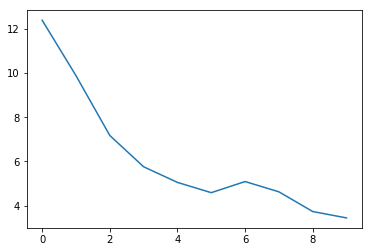

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

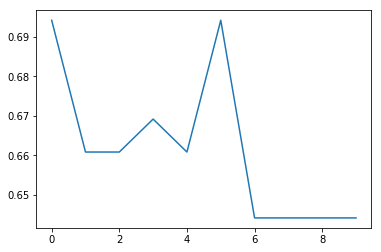

In [0]:
plt.figure()
plt.plot(all_acc)

In [0]:
all_losses

[12.384322751038477,
 9.8779165821924,
 7.170979596003965,
 5.755235892335373,
 5.048955493074577,
 4.584042102399803,
 5.087966388952141,
 4.622629965279775,
 3.7310424472974693,
 3.442262825758561]

In [0]:
df_train

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
1,00RL8Z82B2Z1,aff3928535f48,1541037522,2,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
2,00RL8Z82B2Z1,aff3928535f48,1541037522,3,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
3,00RL8Z82B2Z1,aff3928535f48,1541037532,4,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
4,00RL8Z82B2Z1,aff3928535f48,1541037532,5,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
5,00RL8Z82B2Z1,aff3928535f48,1541037532,6,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
6,00RL8Z82B2Z1,aff3928535f48,1541037532,7,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
7,00RL8Z82B2Z1,aff3928535f48,1541037532,8,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
8,00RL8Z82B2Z1,aff3928535f48,1541037542,9,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
9,00RL8Z82B2Z1,aff3928535f48,1541037542,10,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
10,00RL8Z82B2Z1,aff3928535f48,1541037542,11,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN


In [0]:
def recommendations_from_output(output, hotel_dict, hotels_window, n_features):
  i = 0
  window_dict = {}
  
  output_arr = np.asarray(output[0].cpu().detach().numpy())
    
  ranked_hotels = {}
  
  #for hotel_k, hotel_t in window_dict.items():
  #  d = distance(output, hotel_t)
  #  ranked_hotels[hotel_k] = d
  
  #hotel_scores = {}
  hotel_i = 0
  
  #print(len(output_arr))
  
  for hotel_v in output_arr:
    #print(hotel_v)
    hotel_id = hotel_dict.index2word[hotel_i]
    #print(hotel_id)
    #print(hotel_id)
    #print(hotels_window)
    if hotel_id in hotels_window:
      #print('found')
      ranked_hotels[hotel_id] = hotel_v
    hotel_i = hotel_i + 1
  
  for hotel_id in hotels_window:
    if hotel_id not in ranked_hotels:
      ranked_hotels[hotel_id] = 0
      #print('cant find ' + str(i) + ' sessions')
  
  #ranked_hotels = sorted(ranked_hotels)
  ranked_hotels = sorted(ranked_hotels.items(), key=itemgetter(1))
  #print(ranked_hotels)
  #print(hotels_window)
  #print(ranked_hotels)
  #print(list_to_space_string(ranked_hotels))
  ranked = []
  for tup in ranked_hotels:
    ranked.append(tup[0])
                           
                           
  return list_to_space_string(ranked)


# Just return an output given a line
def evaluate(session, hotel_dict, n_features, hotels_window):
    #hidden = rnn.initHidden()
    hidden = torch.zeros(1, 1, n_hidden)
    c = torch.zeros(1, 1, n_hidden)
    
    #print(session)
    line_tensor = session_to_tensor(session)
    for i in range(line_tensor.size()[0]):
      input = torch.zeros(1, 1, n_features)
      input[0][0] = line_tensor[i]
      input = input.cuda()
      output = model(input)
        
    #print(output)
    output = recommendations_from_output(output, hotel_dict, hotels_window, n_features)

    return output

In [0]:
df_test.iloc[[1]]['session_id'].values[0]

'3599a6f709eab'

In [0]:
df_test['item_recommendations'] = np.nan

test_dim = len(df_test)
temp_session = []
hotels_window = []
i = 0
print_every = 500
step = 0
#df_result = pd.DataFrame(index = [0], columns=df_test.columns)
#print(df_result)

for action_index, action in df_test.iterrows():

  #print(action)
  #print('step ' + str(step))
  #print(len(temp_session)) 
  if(action['reference'] != 'unknown'):
    if (action['action_type'] == 'clickout item') & math.isnan(float(action['reference'])):
      hotels_window = action['impressions'].split('|')
      
      #print('window is ' + str(hotels_window))
      #print(len(temp_session)) 
      
      if len(temp_session) != 0:
        #print('doing sub')
        #print(evaluate(temp_session, hotel_dict, n_features, hotels_window, distance))
        df_test.loc[action_index, 'item_recommendations'] = evaluate(temp_session, hotel_dict, n_features, hotels_window)
        
      #print(p.o)
      temp_session.append(action)
      #print('added click')
    else:
      temp_session.append(action)
      #print(temp_session)
      #print('added action')
    
  if(i < test_dim-1):
    if action['session_id'] != df_test.iloc[[i + 1]]['session_id'].values[0]:
      step = 0
      #print(temp_session)
      #print(hotels_window)
      #print(p.r)
      temp_session = []
      hotels_window = []
    
  i = i+1  
  step = step + 1
    
  if i % print_every == 0:
    perc = (i / test_dim * 100)
    print(str(perc) + '%')
    
#df_result.drop(df_result.head(1).index, inplace=True)

50.45408678102926%


In [0]:
df_test[df_test['item_recommendations'] != np.nan]

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices,item_recommendations
0,02SRUT1NQYH1,3599a6f709eab,1541063730,1,interaction item image,2795374,FI,"Krakow, Poland",mobile,NaN,NaN,NaN,NaN
1,02SRUT1NQYH1,3599a6f709eab,1541063730,2,interaction item image,2795374,FI,"Krakow, Poland",mobile,NaN,NaN,NaN,NaN
2,02SRUT1NQYH1,3599a6f709eab,1541063740,3,interaction item image,2795374,FI,"Krakow, Poland",mobile,NaN,NaN,NaN,NaN
3,02SRUT1NQYH1,3599a6f709eab,1541063740,4,interaction item image,2795374,FI,"Krakow, Poland",mobile,NaN,NaN,NaN,NaN
4,02SRUT1NQYH1,3599a6f709eab,1541063740,5,interaction item image,2795374,FI,"Krakow, Poland",mobile,NaN,NaN,NaN,NaN
5,02SRUT1NQYH1,3599a6f709eab,1541063750,6,interaction item image,2795374,FI,"Krakow, Poland",mobile,NaN,NaN,NaN,NaN
6,02SRUT1NQYH1,3599a6f709eab,1541063760,7,interaction item image,2795374,FI,"Krakow, Poland",mobile,NaN,NaN,NaN,NaN
7,02SRUT1NQYH1,3599a6f709eab,1541063760,8,interaction item image,2795374,FI,"Krakow, Poland",mobile,NaN,NaN,NaN,NaN
8,02SRUT1NQYH1,3599a6f709eab,1541063760,9,interaction item image,2795374,FI,"Krakow, Poland",mobile,NaN,NaN,NaN,NaN
9,02SRUT1NQYH1,3599a6f709eab,1541063770,10,interaction item image,2795374,FI,"Krakow, Poland",mobile,NaN,NaN,NaN,NaN


In [0]:
#evaluate(temp_session, hotel_dict, n_features, hotels_window, distance)

In [0]:
def get_submission_target(df):
    """Identify target rows with missing click outs."""

    mask = df["reference"].isnull() & (df["action_type"] == "clickout item")
    df_out = df[mask]

    return df_out

In [0]:
#for action_index, action in df_sub.iterrows():
#  if type(action['item_recommendations']) is not str:
#  #if math.isnan(float(action['item_recommendations'])):
#    print(df_test[df_test['session_id'] == action['session_id']])
df_test[df_test['session_id'] == 'abc092e6a24e4']

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices,item_recommendations
998,9OBB364GSC67,abc092e6a24e4,1541070808,2,clickout item,NaN,JP,"Nikko, Japan",mobile,NaN,8165056|1587743|3439298|1024902|1024884|102484...,195|312|577|168|162|152|211|125|207|327|308|12...,NaN
999,9OBB364GSC67,abc092e6a24e4,1541070808,3,clickout item,NaN,JP,"Nikko, Japan",mobile,NaN,8165056|1587743|3439298|1024902|1024884|102484...,195|312|577|168|162|152|211|125|207|327|308|12...,1999085 8165056 1587743 3439298 1024902 102488...


In [0]:
df_test

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices,item_recommendations
0,02SRUT1NQYH1,3599a6f709eab,1541063730,1,interaction item image,2795374,FI,"Krakow, Poland",mobile,NaN,NaN,NaN,NaN
1,02SRUT1NQYH1,3599a6f709eab,1541063730,2,interaction item image,2795374,FI,"Krakow, Poland",mobile,NaN,NaN,NaN,NaN
2,02SRUT1NQYH1,3599a6f709eab,1541063740,3,interaction item image,2795374,FI,"Krakow, Poland",mobile,NaN,NaN,NaN,NaN
3,02SRUT1NQYH1,3599a6f709eab,1541063740,4,interaction item image,2795374,FI,"Krakow, Poland",mobile,NaN,NaN,NaN,NaN
4,02SRUT1NQYH1,3599a6f709eab,1541063740,5,interaction item image,2795374,FI,"Krakow, Poland",mobile,NaN,NaN,NaN,NaN
5,02SRUT1NQYH1,3599a6f709eab,1541063750,6,interaction item image,2795374,FI,"Krakow, Poland",mobile,NaN,NaN,NaN,NaN
6,02SRUT1NQYH1,3599a6f709eab,1541063760,7,interaction item image,2795374,FI,"Krakow, Poland",mobile,NaN,NaN,NaN,NaN
7,02SRUT1NQYH1,3599a6f709eab,1541063760,8,interaction item image,2795374,FI,"Krakow, Poland",mobile,NaN,NaN,NaN,NaN
8,02SRUT1NQYH1,3599a6f709eab,1541063760,9,interaction item image,2795374,FI,"Krakow, Poland",mobile,NaN,NaN,NaN,NaN
9,02SRUT1NQYH1,3599a6f709eab,1541063770,10,interaction item image,2795374,FI,"Krakow, Poland",mobile,NaN,NaN,NaN,NaN


In [0]:
df_test[df_test['action_type'] == 'clickout item']

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices,item_recommendations
34,02SRUT1NQYH1,3599a6f709eab,1541063864,35,clickout item,NaN,FI,"Krakow, Poland",mobile,NaN,2795374|5582964|1088390|2781070|1258068|127196...,64|54|36|121|76|81|92|40|73|52|98|104|56|414|6...,3184892 2795374 6652864 3528776 5582964 108839...
40,03K8AXBL4BX2,ec139e10b9238,1541100322,6,clickout item,1032816,UK,"London, United Kingdom",desktop,NaN,12693|46363|81657|18448|47687|152913|18417|927...,104|92|100|103|102|104|72|85|81|75|107|86|98|8...,NaN
41,03K8AXBL4BX2,ec139e10b9238,1541100652,7,clickout item,NaN,UK,"London, United Kingdom",desktop,NaN,12693|46363|81657|18448|47687|152913|18417|927...,104|92|100|103|102|104|72|85|81|75|107|86|98|8...,1032816 12667 98737 18388 12693 106567 1255377...
76,09L0Y03JYTAC,91de23da01b00,1541034697,34,clickout item,NaN,US,"Las Vegas, USA",mobile,NaN,8561|8564|8568|8586|8588|102080|8613|55677|570...,17|37|29|35|97|23|31|62|31|82|52|170|109|97|12...,8588 8561 8602 8568 102080 8586 8564 8599 8618...
97,0O1CTEP95YKQ,af793494b5f84,1541113474,19,clickout item,63051,CO,"Las Vegas, USA",mobile,Breakfast Included|Sort by Price,69086|8533|925367|58949|61049|8581|8517|77520|...,59|66|78|86|87|90|90|92|93|98|99|100|106|108|1...,NaN
98,0O1CTEP95YKQ,af793494b5f84,1541113509,20,clickout item,2851635,CO,"Las Vegas, USA",mobile,Breakfast Included|Sort by Price,69086|8533|925367|58949|61049|8581|8517|77520|...,59|66|78|86|87|90|90|92|93|98|99|100|106|108|1...,NaN
100,0O1CTEP95YKQ,af793494b5f84,1541113537,22,clickout item,NaN,CO,"Las Vegas, USA",mobile,Breakfast Included|Sort by Price,69086|8533|925367|58949|61049|8581|8517|77520|...,59|66|78|86|87|90|90|92|93|98|99|100|106|108|1...,102082 63051 8602 2851635 69086 8533 925367 58...
127,13A1MZHQ298F,b8895e6aa7a2a,1541092320,16,clickout item,50236,FR,"Saint-Valery-sur-Somme, France",desktop,NaN,10441982|6701784|446921|50236|6910372|9706566|...,192|179|227|139|320|375|135,NaN
128,13A1MZHQ298F,b8895e6aa7a2a,1541092497,17,clickout item,50236,FR,"Saint-Valery-sur-Somme, France",desktop,NaN,10441982|6701784|446921|50236|6910372|9706566|...,192|179|227|139|320|375|135,NaN
129,13A1MZHQ298F,b8895e6aa7a2a,1541092540,18,clickout item,10547804,FR,"Saint-Valery-sur-Somme, France",desktop,NaN,10441982|6701784|446921|50236|6910372|9706566|...,192|179|227|139|320|375|135,NaN


In [0]:
df_sub = get_submission_target(df_test)

In [0]:
df_sub = df_sub[['user_id', 'session_id', 'timestamp','step', 'item_recommendations']]

In [0]:
df_sub

,user_id,session_id,timestamp,step,item_recommendations
34,02SRUT1NQYH1,3599a6f709eab,1541063864,35,3184892 2795374 6652864 3528776 5582964 108839...
41,03K8AXBL4BX2,ec139e10b9238,1541100652,7,1032816 12667 98737 18388 12693 106567 1255377...
76,09L0Y03JYTAC,91de23da01b00,1541034697,34,8588 8561 8602 8568 102080 8586 8564 8599 8618...
100,0O1CTEP95YKQ,af793494b5f84,1541113537,22,102082 63051 8602 2851635 69086 8533 925367 58...
155,1MYZFNQNA1JL,73c99d2cd8728,1541107524,2,3953294 3842698 1320620 18904 2530750 152873 1...
355,29MC7779BSXT,574ab911584bb,1541090178,183,2924213 95685 3148916 104811 104800 478096 104...
547,2I4UWBBM5KME,48a7af0123d22,1541101503,190,1321404 53876 53954 53951 53976 106100 1771279...
553,3541XW1IJ5HA,cdcf823180deb,1541063958,2,17949 213106 213901 3382714 18004 3490712 5583...
560,36Z1I286JGTZ,51e521ed97f06,1541082978,7,5806894 2566666 104498 2432711 109363 1084344 ...
715,3WK1Z5XPGA43,48125fbfd5e9e,1541086351,15,4581320 9049620 3382114 3971456 1249659 571469...


In [0]:
for action_index, action in df_gt.iterrows():
  if action_index not in df_sub.index.values.tolist():
    df_gt = df_gt.drop(action_index)
df_gt

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
34,02SRUT1NQYH1,3599a6f709eab,1541063864,35,clickout item,2795374,FI,"Krakow, Poland",mobile,NaN,2795374|5582964|1088390|2781070|1258068|127196...,64|54|36|121|76|81|92|40|73|52|98|104|56|414|6...
41,03K8AXBL4BX2,ec139e10b9238,1541100652,7,clickout item,1032816,UK,"London, United Kingdom",desktop,NaN,12693|46363|81657|18448|47687|152913|18417|927...,104|92|100|103|102|104|72|85|81|75|107|86|98|8...
76,09L0Y03JYTAC,91de23da01b00,1541034697,34,clickout item,8561,US,"Las Vegas, USA",mobile,NaN,8561|8564|8568|8586|8588|102080|8613|55677|570...,17|37|29|35|97|23|31|62|31|82|52|170|109|97|12...
100,0O1CTEP95YKQ,af793494b5f84,1541113537,22,clickout item,8602,CO,"Las Vegas, USA",mobile,Breakfast Included|Sort by Price,69086|8533|925367|58949|61049|8581|8517|77520|...,59|66|78|86|87|90|90|92|93|98|99|100|106|108|1...
155,1MYZFNQNA1JL,73c99d2cd8728,1541107524,2,clickout item,3953294,UK,"Liverpool, United Kingdom",desktop,NaN,3953294|12618|2530750|3842698|18904|706646|106...,299|232|170|237|193|262|163|180|276|251|170|26...
355,29MC7779BSXT,574ab911584bb,1541090178,183,clickout item,104800,BR,"Rio de Janeiro, Brazil",mobile,NaN,104788|3148916|2924213|109353|104706|5763334|1...,475|292|147|439|502|451|497|460|230|368|254|21...
547,2I4UWBBM5KME,48a7af0123d22,1541101503,190,clickout item,53976,US,"Copenhagen, Denmark",desktop,Focus on Distance|Very Good Rating,5953292|53951|53876|9280732|106100|98984|10943...,249|190|139|298|151|178|118|150|180|610|120|11...
553,3541XW1IJ5HA,cdcf823180deb,1541063958,2,clickout item,17949,CH,"Neustrelitz, Germany",desktop,NaN,17949|213106|213901|3382714|18004|3490712|5583...,65|49|82|85|96|70|65|64|117|106|84|140|55|90|6...
560,36Z1I286JGTZ,51e521ed97f06,1541082978,7,clickout item,2566666,BR,"Salvador Bahia, Brazil",mobile,NaN,2566666|1084344|1993467|6625072|1668375|96052|...,27|34|39|36|36|61|59|129|135|42|71|33|54|34|40...
715,3WK1Z5XPGA43,48125fbfd5e9e,1541086351,15,clickout item,4581320,CO,"Playa del Carmen, Mexico",mobile,House / Apartment|Sort by Price,3382114|4581320|3971456|1249659|5714694|829771...,26|26|27|27|28|29|31|31|31|34|35|35|35|36|36|3...


In [0]:
word2vec.wv.most_similar(positive = '1319094')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('1030646', 0.99560546875),
 ('149589', 0.9953914880752563),
 ('925325', 0.995133638381958),
 ('10091602', 0.9950528740882874),
 ('162910', 0.9950293302536011),
 ('2682060', 0.9950289726257324),
 ('11984', 0.9949899911880493),
 ('136732', 0.994960367679596),
 ('345196', 0.9948869943618774),
 ('880913', 0.9948232173919678)]

In [0]:
mask = df_sub["item_recommendations"].notnull()
df_sub = df_sub[mask]

In [0]:
def get_reciprocal_ranks(ps):
    """Calculate reciprocal ranks for recommendations."""
    mask = ps.reference == np.array(ps.item_recommendations)

    if mask.sum() == 1:
        rranks = generate_rranks_range(0, len(ps.item_recommendations))
        return np.array(rranks)[mask].min()
    else:
        return 0.0


def score_submissions(subm_csv, gt_csv, objective_function):
    """Score submissions with given objective function."""

    print(f"Reading ground truth data {gt_csv} ...")
    df_gt = read_into_df(gt_csv)

    print(f"Reading submission data {subm_csv} ...")
    df_subm = read_into_df(subm_csv)

    # create dataframe containing the ground truth to target rows
    cols = ['reference', 'impressions', 'prices']
    df_key = df_gt.loc[:, cols]

    # append key to submission file
    df_subm_with_key = df_key.join(df_subm, how='inner')
    df_subm_with_key.reference = df_subm_with_key.reference.astype(int)
    df_subm_with_key = convert_string_to_list(
        df_subm_with_key, 'item_recommendations', 'item_recommendations'
    )

    # score each row
    df_subm_with_key['score'] = df_subm_with_key.apply(objective_function, axis=1)
    mrr = df_subm_with_key.score.mean()

    return mrr
  
def generate_rranks_range(start, end):
    """Generate reciprocal ranks for a given list length."""

    return 1.0 / (np.arange(start, end) + 1)
  
def convert_string_to_list(df, col, new_col):
    """Convert column from string to list format."""
    fxn = lambda arr_string: [int(item) for item in str(arr_string).split(" ")]

    mask = ~(df[col].isnull())

    df[new_col] = df[col]
    df.loc[mask, new_col] = df[mask][col].map(fxn)

    return df


def get_reciprocal_ranks(ps):
    """Calculate reciprocal ranks for recommendations."""
    mask = ps.reference == np.array(ps.item_recommendations)

    if mask.sum() == 1:
        rranks = generate_rranks_range(0, len(ps.item_recommendations))
        return np.array(rranks)[mask].min()
    else:
        return 0.0
  

def score_submissions_no_csv(df_subm, df_gt, objective_function):
    # create dataframe containing the ground truth to target rows
    cols = ['reference', 'impressions', 'prices']
    df_key = df_gt.loc[:, cols]

    # append key to submission file
    df_subm_with_key = df_key.join(df_subm, how='inner')
    df_subm_with_key.reference = df_subm_with_key.reference.astype(int)
    df_subm_with_key = convert_string_to_list(
        df_subm_with_key, 'item_recommendations', 'item_recommendations'
    )

    # score each row
    df_subm_with_key['score'] = df_subm_with_key.apply(objective_function, axis=1)
    mrr = df_subm_with_key.score.mean()

    return mrr

In [0]:
mrr = score_submissions_no_csv(df_sub, df_gt, get_reciprocal_ranks)
print("End execution with score " + str(mrr))

End execution with score 0.6441666666666667


In [0]:
df_temp = df_test[df_test['user_id'] == '68Q297NAT23H']

In [0]:
df_temp

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices,item_recommendations
833,68Q297NAT23H,05a03c73a94c0,1541099529,1,interaction item image,70378,US,"Durango, USA",desktop,NaN,NaN,NaN,NaN
834,68Q297NAT23H,05a03c73a94c0,1541099529,2,interaction item image,70378,US,"Durango, USA",desktop,NaN,NaN,NaN,NaN
835,68Q297NAT23H,05a03c73a94c0,1541099531,3,clickout item,70378,US,"Durango, USA",desktop,NaN,61552|71939|76124|2788104|1005791|70378|581704...,67|85|61|98|55|80|85|59|63|110|75|102|60|114|7...,NaN
836,68Q297NAT23H,05a03c73a94c0,1541099619,4,clickout item,NaN,US,"Durango, USA",desktop,NaN,61552|71939|76124|2788104|1005791|70378|581704...,67|85|61|98|55|80|85|59|63|110|75|102|60|114|7...,71939 70378 61552 76124 2788104 1005791 581704...


In [0]:
df_temp = df_temp.drop(df_temp[df_temp['step'] == 3].index)

In [0]:
test_accuracy(df_temp, df_gt)

Score: 0.05555555555555555


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [0]:
session = []
hotel_window = []
for action_i, action in df_temp.iterrows():
  if (action['action_type'] == 'clickout item') & math.isnan(float(action['reference'])):
    hotel_window = action['impressions'].split('|')
  session.append(action)

In [0]:
session

[user_id                           68Q297NAT23H
 session_id                       05a03c73a94c0
 timestamp                           1541099529
 step                                         1
 action_type             interaction item image
 reference                                70378
 platform                                    US
 city                              Durango, USA
 device                                 desktop
 current_filters                            NaN
 impressions                                NaN
 prices                                     NaN
 item_recommendations                       NaN
 Name: 833, dtype: object, user_id                           68Q297NAT23H
 session_id                       05a03c73a94c0
 timestamp                           1541099529
 step                                         2
 action_type             interaction item image
 reference                                70378
 platform                                    US
 city         

In [0]:
evaluate(session, hotel_dict, n_features, hotel_window)

'71939 70378 61552 76124 2788104 1005791 5817042 76473 68150 956945 68152 1080302 1005795 1005783 70668 2523598 1136747 78692 5790672 77565 72040 3222546 68151 1005779 9866510'

In [0]:
df_test[df_test['user_id'] == '1MYZFNQNA1JL']

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices,item_recommendations
154,1MYZFNQNA1JL,73c99d2cd8728,1541107510,1,search for item,3953294,UK,"Liverpool, United Kingdom",desktop,NaN,NaN,NaN,NaN
155,1MYZFNQNA1JL,73c99d2cd8728,1541107524,2,clickout item,NaN,UK,"Liverpool, United Kingdom",desktop,NaN,3953294|12618|2530750|3842698|18904|706646|106...,299|232|170|237|193|262|163|180|276|251|170|26...,3953294 3842698 1320620 18904 2530750 152873 1...
